In [2]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from ast import literal_eval
import pandas as pd
import numpy as np

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
#from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs
import fasttext as ft
from nltk.tokenize import WhitespaceTokenizer
import pickle
from tensorflow.keras.utils import to_categorical

2022-11-14 09:56:00.420539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-14 09:56:00.420563: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
data=pd.read_csv('data.csv',header=None)

In [4]:
data = data.sample(frac=1)

In [5]:
print(f"There are {len(data)} rows in the dataset.")

There are 82657 rows in the dataset.


In [6]:
data.shape

(82657, 11)

In [7]:
data.head(1)

,0,1,2,3,4,5,6,7,8,9,10
31134,44571,http://arxiv.org/abs/2204.06849v1,Ensuring accurate stain reproduction in deep g...,Immunohistochemistry is a valuable diagnostic ...,NaN,2022-04-14 09:51:04+00:00,eess.IV,NaN,"Eighteen pages, six figures","[arxiv.Result.Author('Christopher D. Walsh'), ...",eess


In [8]:
test_split = 0.2

# Initial train and test split.
train_df, test_df = train_test_split(data,test_size=test_split)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 66125
Number of rows in test set: 16532


In [9]:
train_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10
30560,195823,http://arxiv.org/abs/2004.07311v1,Edge Computing For Smart Health: Context-aware...,Improving efficiency of healthcare systems is ...,"IEEE Network (Volume: 33 , Issue: 3 , May/June...",2020-04-15 19:50:24+00:00,eess.SP,10.1109/MNET.2019.1800083,NaN,"[arxiv.Result.Author('Alaa Awad Abdellatif'), ...",eess


In [10]:
#processing label of training/testing data
label_train=train_df[10].values
label_test=test_df[10].values
#print(label_test)
catg=['physics', 'cs', 'q-bio', 'math', 'eess']
num_classes = len(catg)
mapping = {}
for x in range(len(catg)):
    mapping[catg[x]] = x
    
# integer representation
for x in range(len(label_train)):
    label_train[x] = mapping[label_train[x]]
#processing lebal of testing data

# integer representation
for x in range(len(label_test)):
    label_test[x] = mapping[label_test[x]]
  
#conveting to one-hot-encoding
y_train = to_categorical(label_train)
y_test=to_categorical(label_test)  

In [11]:
train_df[3].apply(lambda x: len(x.split(" "))).describe()

count    66125.000000
mean       163.327758
std         59.288694
min          6.000000
25%        121.000000
50%        162.000000
75%        203.000000
max        530.000000
Name: 3, dtype: float64

In [12]:
tokenizer = WhitespaceTokenizer()
raw_docs_train = train_df[3].tolist()
raw_docs_test = test_df[3].tolist() 

In [13]:
print("pre-processing train data...")
processed_docs_train = []
for line in tqdm(raw_docs_train):
    #line=text_cleaner(line)
    tokens = tokenizer.tokenize(line)
    #filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(tokens))
#end for

pre-processing train data...


100%|██████████████████████████████████| 66125/66125 [00:02<00:00, 27957.99it/s]


In [14]:
print("pre-processing test data...")
processed_docs_test = []
for line in tqdm(raw_docs_test):
    #line=text_cleaner(line)
    tokens = tokenizer.tokenize(line)
    #filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(tokens))

pre-processing test data...


100%|██████████████████████████████████| 16532/16532 [00:00<00:00, 27759.84it/s]


In [16]:
max_seq_len = 175

In [17]:
MAX_NB_WORDS = 500000
print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

tokenizing input data...
dictionary size:  131631


In [18]:
import pickle

# saving
with open('dic_main_cat.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
#loading embedding
ft_model = ft.load_model("cc.en.300.bin")

In [20]:
from keras_preprocessing.sequence import pad_sequences

In [21]:
#pad sequences
word_seq_train = pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = pad_sequences(word_seq_test, maxlen=max_seq_len)    

In [22]:
print(word_seq_train[12])

[ 2191 41675     1  1100   945   640   957   115   137  4294  1260   143
   853 30824     3 58942  2548   115  1830    26    55  3960    78     1
   245   356  5402  3259   944     2     4   710    58     5  5211   120
    32   115  2889  1610    26  3960  1565 30825     6    13    35     7
    66     1  1133     2 24450   558   143    10  2869   158 30824 58942
    15  1243   680     5  1524   746  1957    24   450  1343     3   115
     6   120    32    26     1   838  1689 41676   558  1689 23433 24450
  3989   120    32    24    18     1  5402    16    74    16  4963    72
    18     1   545   120    32 19667     3  5211   580     3   115     2
   388   467  5185   275  1598    84   344    11 18623  2549  1065    90
   352   456    15     1 41675    37    16  1036  1343     3   374  2286
     7    66  1848  1827     5  2409 24450     6     1   356  5402   350
    15  1722     3  2220  1857     3   523  1617    82  8109   246     7
   424   489   259     5 24450     3   116  2552   

In [23]:
#embedding matrix
embed_dim = 300
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = ft_model.get_word_vector(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 28


In [24]:
#model parameters
num_filters = 30
weight_decay = 1e-4

In [25]:
#CNN architecture
print("CNN architecture")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 5, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 5, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='softmax'))  #multi-label (k-hot encoding)
adam = tf.optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

CNN architecture


2022-11-14 10:02:37.911704: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-14 10:02:37.922610: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-14 10:02:37.928898: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (saurabh-hp-prodesk): /proc/driver/nvidia/version does not exist
2022-11-14 10:02:37.972508: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 10:02:38.070743: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 15795840

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 175, 300)          39489600  
                                                                 
 conv1d (Conv1D)             (None, 175, 30)           45030     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 87, 30)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 87, 30)            4530      
                                                                 
 global_max_pooling1d (Globa  (None, 30)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 30)                0

In [26]:
#training params
batch_size = 256
num_epochs = 100

In [27]:
#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [28]:
#model training
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_split=0.1, shuffle=True, verbose=1, callbacks=[es])

2022-11-14 10:02:52.564234: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 41658400 exceeds 10% of free system memory.


Epoch 1/100
233/233 [==============================] - 16s 67ms/step - loss: 0.4327 - accuracy: 0.4467 - val_loss: 0.3023 - val_accuracy: 0.6536
Epoch 2/100
233/233 [==============================] - 15s 66ms/step - loss: 0.3047 - accuracy: 0.6650 - val_loss: 0.2657 - val_accuracy: 0.7095
Epoch 3/100
233/233 [==============================] - 16s 67ms/step - loss: 0.2767 - accuracy: 0.7026 - val_loss: 0.2497 - val_accuracy: 0.7323
Epoch 4/100
233/233 [==============================] - 17s 75ms/step - loss: 0.2590 - accuracy: 0.7229 - val_loss: 0.2371 - val_accuracy: 0.7434
Epoch 5/100
233/233 [==============================] - 19s 81ms/step - loss: 0.2444 - accuracy: 0.7458 - val_loss: 0.2225 - val_accuracy: 0.7768
Epoch 6/100
233/233 [==============================] - 17s 73ms/step - loss: 0.2324 - accuracy: 0.7626 - val_loss: 0.2119 - val_accuracy: 0.7906
Epoch 7/100
233/233 [==============================] - 16s 69ms/step - loss: 0.2205 - accuracy: 0.7768 - val_loss: 0.2049 - val_ac

In [29]:
from matplotlib import pyplot

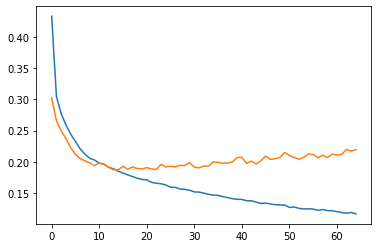

In [30]:
pyplot.plot(hist.history['loss'], label='train')
pyplot.plot(hist.history['val_loss'], label='test')

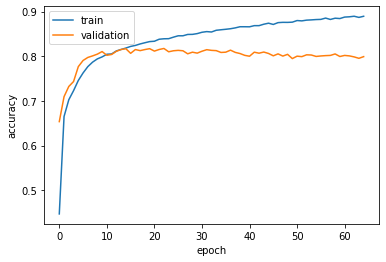

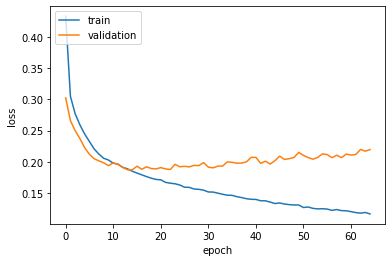

In [31]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
#plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("main_cat_cnn_acc.pdf", format="pdf", bbox_inches="tight")
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
#plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("main_cat_cnn_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [32]:
model.save('main_cat_predector_cnn.h5')

In [33]:
# evaluate the model
_, train_acc = model.evaluate(word_seq_train, y_train, verbose=1)
_, test_acc = model.evaluate(word_seq_test, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

517/517 [==============================] - 2s 3ms/step - loss: 0.2096 - accuracy: 0.8053
Train: 0.921, Test: 0.805


In [34]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Dropout

In [35]:
#Bi-LSTM
lstm_out=128
model_LSTM = keras.Sequential()
model_LSTM.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model_LSTM.add(Bidirectional(LSTM(lstm_out, dropout=0.2)))
model_LSTM.add(Dense(128, activation = 'relu'))
model_LSTM.add(Dropout(0.5))
model_LSTM.add(Dense(64, activation = 'relu'))
model_LSTM.add(Dense(num_classes, activation='softmax'))  #multi-label (k-hot encoding)
adam = tf.optimizers.Adam()
model_LSTM.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 175, 300)          39489600  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 5)                 325       
                                                      

In [36]:
from keras.callbacks import ModelCheckpoint

In [37]:
mc = ModelCheckpoint('main_cat_predictor_biLstm.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [38]:
#training params
batch_size_LSTM = 256
num_epochs_LSTM = 100

In [39]:
hist_LSTM = model_LSTM.fit(word_seq_train, y_train, batch_size=batch_size_LSTM, epochs=num_epochs_LSTM,validation_split=0.1, shuffle=True, verbose=1,callbacks=[es, mc])

Epoch 1/100
233/233 [==============================] - ETA: 0s - loss: 0.3831 - accuracy: 0.5069
Epoch 1: val_accuracy improved from -inf to 0.67398, saving model to main_cat_predictor_biLstm.h5
233/233 [==============================] - 111s 461ms/step - loss: 0.3831 - accuracy: 0.5069 - val_loss: 0.2839 - val_accuracy: 0.6740
Epoch 2/100
233/233 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.6979
Epoch 2: val_accuracy improved from 0.67398 to 0.73945, saving model to main_cat_predictor_biLstm.h5
233/233 [==============================] - 110s 471ms/step - loss: 0.2686 - accuracy: 0.6979 - val_loss: 0.2424 - val_accuracy: 0.7395
Epoch 3/100
233/233 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.7628
Epoch 3: val_accuracy improved from 0.73945 to 0.78467, saving model to main_cat_predictor_biLstm.h5
233/233 [==============================] - 109s 470ms/step - loss: 0.2283 - accuracy: 0.7628 - val_loss: 0.2137 - val_accuracy: 0.7847
Epoc

Epoch 27/100
233/233 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.8877
Epoch 27: val_accuracy did not improve from 0.83684
233/233 [==============================] - 100s 429ms/step - loss: 0.1097 - accuracy: 0.8877 - val_loss: 0.1951 - val_accuracy: 0.8314
Epoch 28/100
233/233 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.8913
Epoch 28: val_accuracy did not improve from 0.83684
233/233 [==============================] - 99s 425ms/step - loss: 0.1073 - accuracy: 0.8913 - val_loss: 0.1997 - val_accuracy: 0.8285
Epoch 29/100
233/233 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.8948
Epoch 29: val_accuracy did not improve from 0.83684
233/233 [==============================] - 99s 426ms/step - loss: 0.1048 - accuracy: 0.8948 - val_loss: 0.1933 - val_accuracy: 0.8231
Epoch 30/100
233/233 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.8998
Epoch 30: val_accuracy did not improve from 0.836

Epoch 56/100
233/233 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9671
Epoch 56: val_accuracy did not improve from 0.83684
233/233 [==============================] - 97s 416ms/step - loss: 0.0349 - accuracy: 0.9671 - val_loss: 0.3533 - val_accuracy: 0.8234
Epoch 57/100
233/233 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9688
Epoch 57: val_accuracy did not improve from 0.83684
233/233 [==============================] - 99s 425ms/step - loss: 0.0333 - accuracy: 0.9688 - val_loss: 0.3366 - val_accuracy: 0.8235
Epoch 58/100
233/233 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9692
Epoch 58: val_accuracy did not improve from 0.83684
233/233 [==============================] - 99s 425ms/step - loss: 0.0326 - accuracy: 0.9692 - val_loss: 0.3538 - val_accuracy: 0.8250
Epoch 59/100
233/233 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9699
Epoch 59: val_accuracy did not improve from 0.8368

In [40]:
# evaluate the model
_, train_acc = model_LSTM.evaluate(word_seq_train, y_train, verbose=1)
_, test_acc = model_LSTM.evaluate(word_seq_test, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

517/517 [==============================] - 19s 36ms/step - loss: 0.3829 - accuracy: 0.8161
Train: 0.978, Test: 0.816


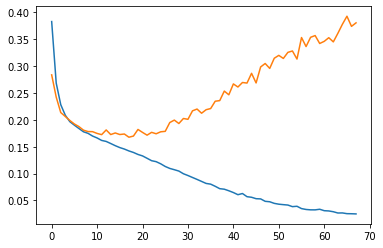

In [41]:
pyplot.plot(hist_LSTM.history['loss'], label='train')
pyplot.plot(hist_LSTM.history['val_loss'], label='test')

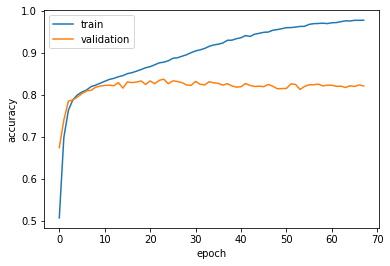

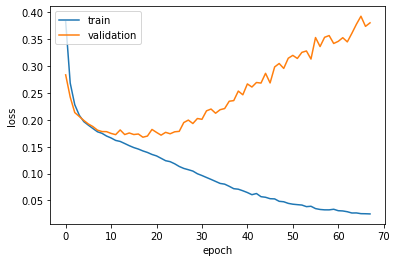

In [42]:
plt.plot(hist_LSTM.history['accuracy'])
plt.plot(hist_LSTM.history['val_accuracy'])
#plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("main_cat_lstm_acc.pdf", format="pdf", bbox_inches="tight")
plt.show()
# summarize history for loss
plt.plot(hist_LSTM.history['loss'])
plt.plot(hist_LSTM.history['val_loss'])
#plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("main_cat_lstm_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()